# Google Colab Setup

In [1]:
# !pip install 'transformers[torch]'
# !pip install pytorch-transformers
# !pip install tensorboardX
# ! pip install transformers
# ! pip install Ipython --upgrade

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
# from transformers import get_linear_schedule_with_warmup
# from transformers.optimization import AdamW
import sys
from sys import platform
import re
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

## Mount Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# # drive.mount('/content/gdrive')

In [4]:
# home = Path('/content/gdrive/MyDrive/Columbia/RobustStatistics/sentiment-influence-function/')
# src_path = str(home / 'src')

# if src_path not in sys.path:
#   # Put scripts on the path.
#   sys.path.insert(0, src_path)

## Set up GPU

In [5]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Load Dataset

In [6]:

data_path = Path('data')

In [7]:
train_df = pd.read_csv(data_path / 'train.csv')
test_df = pd.read_csv(data_path / 'test.csv')
val_df = pd.read_csv(data_path / 'val.csv')

print(f"train: {len(train_df)}")
print(f"test: {len(test_df)}")
print(f"val: {len(val_df)}")

train: 67349
test: 1821
val: 872


In [8]:
x_train = train_df.sentence
y_train = train_df.label

x_val = val_df.sentence
y_val = val_df.label

x_test = test_df.sentence
y_test = test_df.label

# Naive Bayes Classifier

Best alpha:  1.5


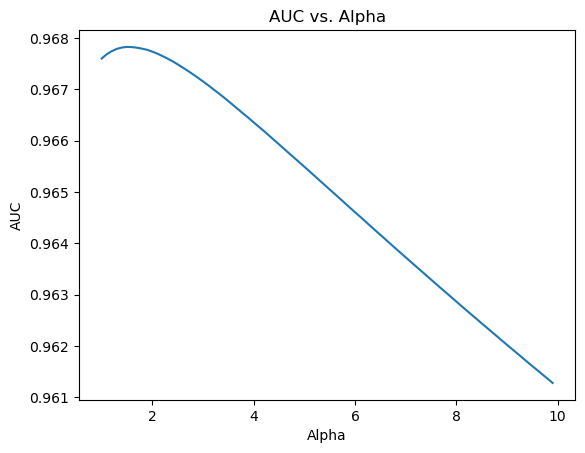

CPU times: user 20.1 s, sys: 105 ms, total: 20.2 s
Wall time: 21.9 s


In [12]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(np.array(x_train))
X_val_tfidf = tf_idf.transform(np.array(x_val))
X_test_tfidf = tf_idf.transform(np.array(x_test))

from sklearn.naive_bayes import MultinomialNB
from src.utils import get_auc_CV

res = pd.Series(data=[get_auc_CV(MultinomialNB(alpha=i), X_train_tfidf, y_train) for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

AUC: 0.9099
Accuracy: 78.67%


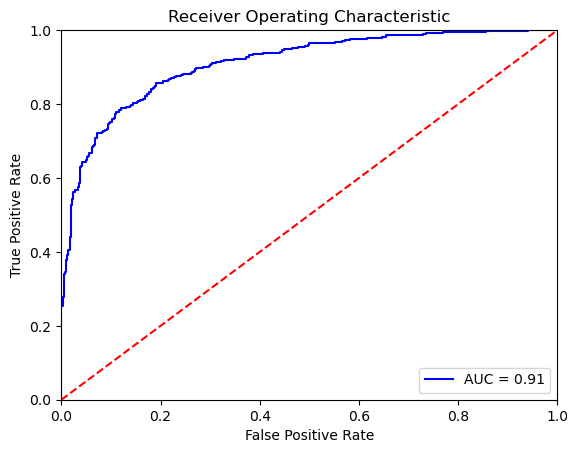

In [13]:
from src.utils import evaluate_roc

# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

AUC: 0.9094
Accuracy: 79.24%


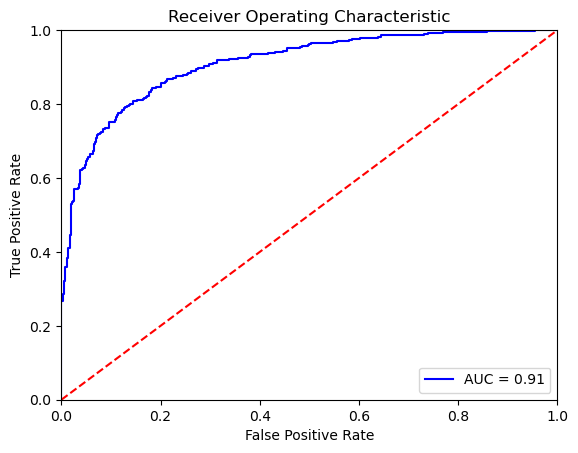

In [14]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.5)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

# Influence Function